In [2]:
# import kaggle
# import zipfile
#
# # kaggle datasets download -d ramzanlafir/cat-breed-classification-11-classes
# with zipfile.ZipFile("cat-breed-classification-11-classes.zip", "r") as zip_ref:
#      zip_ref.extractall("cat-breed-classification-11-classes")

In [51]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from collections import Counter

import os
import time
import math

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [4]:
plot_data = {
    "fastAI": 0,
    "RawCNN": 0,
    "CleanCNN": 0,
    "YOLOv11": 0,
}

In [72]:
plot_data

{'fastAI': [np.float64(0.9781685870224378),
  12898.937529563904,
  255.45963621139526,
  array([[126,   0,   0,   0,   0,   1,   0,   3,   0,   0,   0],
         [  0, 149,   0,   0,   0,   1,   0,   0,   0,   0,   0],
         [  0,   1, 147,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   1,   2, 150,   2,   0,   1,   0,   1,   0,   0],
         [  0,   0,   1,   0, 148,   0,   1,   1,   0,   2,   0],
         [  0,   0,   0,   0,   0, 154,   2,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   2, 143,   0,   0,   1,   0],
         [  0,   3,   0,   0,   0,   0,   0, 150,   0,   0,   0],
         [  0,   0,   0,   3,   0,   0,   0,   1, 134,   0,   0],
         [  0,   0,   0,   0,   2,   0,   1,   0,   0, 150,   0],
         [  0,   1,   0,   0,   0,   0,   0,   2,   0,   0, 162]])],
 'RawCNN': [0.5481818181818182,
  2410.4158041477203,
  18.642431259155273,
  array([[79,  1, 10,  6,  2,  1,  1,  1,  7,  9,  3],
         [ 0, 87,  0,  1,  1,  1,  0,  1,  0,  2,  1

In [113]:
# Save data
import pickle
with open('session.pkl', 'wb') as f:
    pickle.dump(plot_data, f)

In [5]:
# Load data
import pickle
with open('session.pkl', 'rb') as f:
    plot_data = pickle.load(f)

1. Raw Input + fastAI

In [22]:
from fastcore.all import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.metrics import accuracy as fastaiaccuracy

In [11]:
def get_data(path, img_size=224, batch_size=32):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=parent_label,
        splitter=RandomSplitter(valid_pct=0.3, seed=23),
        item_tfms=[RandomResizedCrop(img_size, min_scale=0.8)],
        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path, bs=batch_size)

def train_model(dls, model_arch=resnet34, epochs=5):
    learn = vision_learner(dls, model_arch, metrics=[error_rate, accuracy])
    learn.fine_tune(epochs, cbs=[
        SaveModelCallback(monitor='accuracy', fname='best_model'),
        CSVLogger(),
        EarlyStoppingCallback(monitor='accuracy', patience=3)
    ])
    return learn

dls = get_data("cat-breed-classification-11-classes/Cat_Breed")

In [12]:
train_start = time.time()
learn = train_model(dls)
train_time = time.time() - train_start

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.881811,0.289958,0.095816,0.904184,26:24


Better model found at epoch 0 with accuracy value: 0.9041843414306641.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.272745,0.151212,0.051546,0.948454,34:09
1,0.252230,0.130104,0.040024,0.959976,34:06
2,0.149823,0.093185,0.030928,0.969072,45:12
3,0.075509,0.081511,0.021831,0.978169,42:46
4,0.050795,0.077132,0.024257,0.975743,32:17


Better model found at epoch 0 with accuracy value: 0.9484536051750183.
Better model found at epoch 1 with accuracy value: 0.9599757194519043.
Better model found at epoch 2 with accuracy value: 0.969072163105011.
Better model found at epoch 3 with accuracy value: 0.9781686067581177.


In [ ]:
test_start = time.time()
interp = ClassificationInterpretation.from_learner(learn)
test_time = time.time() - test_start

In [ ]:
confusion = interp.confusion_matrix()

In [27]:
accuracy = np.trace(confusion) / np.sum(confusion)

plot_data["fastAI"] = [accuracy, train_time, test_time, confusion]

print("Accuracy:", accuracy)
print("Train Time:", train_time)
print("Test Time:", test_time)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.9781685870224378
Train Time: 12898.937529563904
Test Time: 255.45963621139526
Confusion Matrix:
 [[126   0   0   0   0   1   0   3   0   0   0]
 [  0 149   0   0   0   1   0   0   0   0   0]
 [  0   1 147   0   0   0   0   0   0   0   0]
 [  0   1   2 150   2   0   1   0   1   0   0]
 [  0   0   1   0 148   0   1   1   0   2   0]
 [  0   0   0   0   0 154   2   0   0   0   0]
 [  0   0   0   0   0   2 143   0   0   1   0]
 [  0   3   0   0   0   0   0 150   0   0   0]
 [  0   0   0   3   0   0   0   1 134   0   0]
 [  0   0   0   0   2   0   1   0   0 150   0]
 [  0   1   0   0   0   0   0   2   0   0 162]]


1.5. CNN Data

In [25]:
main_path = "cat-breed-classification-11-classes"
raw_path = main_path + "/Cat_Breed"
crop_path = main_path + "/Cropped_Cat_Breed"

In [31]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.conf = 0.4

def crop_to_object(image_path, output_path):
    img = cv2.imread(image_path)
    results = model(img)

    for *box, conf, cls in results.xyxy[0]:
        if int(cls) == 15:  # class 15 = cat
            x1, y1, x2, y2 = map(int, box)
            cropped = img[y1:y2, x1:x2]
            cv2.imwrite(output_path, cropped)
            print(f"Cropped {image_path}")
            return True
    cropped = img
    cv2.imwrite(output_path, cropped)
    print(f"Fail to crop {image_path}")
    return False

for species in os.listdir(raw_path):
    for image in os.listdir(f"{raw_path}/{species}"):
        old_path = f"{raw_path}/{species}/{image}"
        new_path = f"{crop_path}/{species}/{image}"
        crop_to_object(old_path, new_path)

Using cache found in C:\Users\Cenneth/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-6-3 Python-3.10.7 torch-2.7.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_0.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_10.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_100.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_101.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_104.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_106.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_107.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_108.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_109.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_110.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_115.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/abys_116.jpg
Cropped cat-breed-classification-11-classes/Cat_Breed/Abyssinian/ab

In [32]:
raw_imagelist = []
raw_specieslist = []

cropped_imagelist = []
cropped_specieslist = []

os.makedirs(crop_path, exist_ok=True)

for species in os.listdir(raw_path):
    for image in os.listdir(f"{raw_path}/{species}"):
        path = f"{raw_path}/{species}/{image}"
        raw_imagelist.append(path)
        raw_specieslist.append(species)

for species in os.listdir(crop_path):
    for image in os.listdir(f"{crop_path}/{species}"):
        path = f"{crop_path}/{species}/{image}"
        cropped_imagelist.append(path)
        cropped_specieslist.append(species)

raw_df = pd.DataFrame({"image": raw_imagelist, "species": raw_specieslist})
cropped_df = pd.DataFrame({"image": cropped_imagelist, "species": cropped_specieslist})

print("Raw:")
print(raw_df.head())
print("Cropped:")
print(cropped_df.head())

Raw:
                                               image     species
0  cat-breed-classification-11-classes/Cat_Breed/...  Abyssinian
1  cat-breed-classification-11-classes/Cat_Breed/...  Abyssinian
2  cat-breed-classification-11-classes/Cat_Breed/...  Abyssinian
3  cat-breed-classification-11-classes/Cat_Breed/...  Abyssinian
4  cat-breed-classification-11-classes/Cat_Breed/...  Abyssinian
Cropped:
                                               image     species
0  cat-breed-classification-11-classes/Cropped_Ca...  Abyssinian
1  cat-breed-classification-11-classes/Cropped_Ca...  Abyssinian
2  cat-breed-classification-11-classes/Cropped_Ca...  Abyssinian
3  cat-breed-classification-11-classes/Cropped_Ca...  Abyssinian
4  cat-breed-classification-11-classes/Cropped_Ca...  Abyssinian


2. Raw Input + CNN

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [58]:
X_train, X_test, y_train, y_test = train_test_split(raw_df["image"], raw_df["species"], test_size=0.2, random_state=42)

traindf = pd.DataFrame({"image": X_train, "species": y_train})
testdf = pd.DataFrame({"image": X_test, "species": y_test})

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print(traindf)
print(testdf)

                                                  image           species
4315  cat-breed-classification-11-classes/Cat_Breed/...     Scottish Fold
1832  cat-breed-classification-11-classes/Cat_Breed/...  Exotic Shorthair
3819  cat-breed-classification-11-classes/Cat_Breed/...      Russian Blue
957   cat-breed-classification-11-classes/Cat_Breed/...            Bombay
3545  cat-breed-classification-11-classes/Cat_Breed/...      Russian Blue
...                                                 ...               ...
3772  cat-breed-classification-11-classes/Cat_Breed/...      Russian Blue
5191  cat-breed-classification-11-classes/Cat_Breed/...            Sphynx
5226  cat-breed-classification-11-classes/Cat_Breed/...            Sphynx
5390  cat-breed-classification-11-classes/Cat_Breed/...            Sphynx
860   cat-breed-classification-11-classes/Cat_Breed/...            Bombay

[4399 rows x 2 columns]
                                                  image           species
4747  cat-bre

In [59]:
image_size = (128, 128)
batch_size = 32
num_classes = len(traindf["species"].unique())

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col="image",
    y_col="species",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col="image",
    y_col="species",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print(train_generator.class_indices)
print(test_generator.class_indices)

Found 4399 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
{'Abyssinian': 0, 'Bombay': 1, 'Egyptian Mau': 2, 'Exotic Shorthair': 3, 'Himalayan': 4, 'Maine Coon': 5, 'Regdoll': 6, 'Russian Blue': 7, 'Scottish Fold': 8, 'Siamese': 9, 'Sphynx': 10}
{'Abyssinian': 0, 'Bombay': 1, 'Egyptian Mau': 2, 'Exotic Shorthair': 3, 'Himalayan': 4, 'Maine Coon': 5, 'Regdoll': 6, 'Russian Blue': 7, 'Scottish Fold': 8, 'Siamese': 9, 'Sphynx': 10}


In [60]:
input_shape = (128, 128, 3) # 128x128, RGB

model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,059 (12.61 MB)

 Trainable params: 3,306,059 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
]

train_start = time.time()
modelfit = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=callbacks)
train_time = time.time() - train_start

history = modelfit.history

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 126s 903ms/step - accuracy: 0.2516 - loss: 2.1231 - val_accuracy: 0.3018 - val_loss: 2.0070
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 122s 881ms/step - accuracy: 0.3048 - loss: 1.9827 - val_accuracy: 0.3555 - val_loss: 1.9055
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 124s 901ms/step - accuracy: 0.3392 - loss: 1.9087 - val_accuracy: 0.3809 - val_loss: 1.8543
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 124s 903ms/step - accuracy: 0.3729 - loss: 1.8294 - val_accuracy: 0.3891 - val_loss: 1.7973
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 118s 854ms/step - accuracy: 0.3924 - loss: 1.7551 - val_accuracy: 0.3582 - val_loss: 1.8194
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 119s 862ms/step - accuracy: 0.4119 - loss: 1.6982 - val_accuracy: 0.4145 - val_loss: 1.7341
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 117s 849ms/step - accuracy: 0.4431 - loss: 1.6536 - val_accuracy: 0.4391 - val_loss: 1.6328
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 118s 857ms/step - accuracy: 0.4593 -

In [82]:
y_true = test_generator.classes

test_start = time.time()
y_pred_probs = model.predict(test_generator, verbose=1)
test_time = time.time() - test_start

y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)

plot_data["RawCNN"] = [accuracy, train_time, test_time, confusion]

print("Accuracy:", accuracy)
print("Train Time:", train_time)
print("Test Time:", test_time)
print("Confusion Matrix:\n", confusion)

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 490ms/step
Accuracy: 0.5481818181818182
Train Time: 2410.4158041477203
Test Time: 18.642431259155273
Confusion Matrix:
 [[79  1 10  6  2  1  1  1  7  9  3]
 [ 0 87  0  1  1  1  0  1  0  2  1]
 [ 3  0 78  4  0 10  2  6  3  1  1]
 [11  2  8 23  5  9  9  3 18  8  4]
 [ 1  2  2  3 63  6  4  5  3 18  1]
 [ 4  2 11  4  3 35 11  4  4  8  5]
 [ 0  0  0  3  6  3 57  0  6  5  9]
 [ 5  3 10  0  3  8  1 46  9  4  0]
 [ 7  1  9 11  5 10 10  9 25  4  2]
 [ 4  2  1  1 20  2  0  2  3 71  0]
 [ 9  4 10  5  5  6  4  8  3  9 39]]


3. Clean Input + CNN

In [40]:
X_train, X_test, y_train, y_test = train_test_split(cropped_df["image"], cropped_df["species"], test_size=0.2, random_state=42)

traindf = pd.DataFrame({"image": X_train, "species": y_train})
testdf = pd.DataFrame({"image": X_test, "species": y_test})

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print(traindf)
print(testdf)

                                                  image           species
4315  cat-breed-classification-11-classes/Cropped_Ca...     Scottish Fold
1832  cat-breed-classification-11-classes/Cropped_Ca...  Exotic Shorthair
3819  cat-breed-classification-11-classes/Cropped_Ca...      Russian Blue
957   cat-breed-classification-11-classes/Cropped_Ca...            Bombay
3545  cat-breed-classification-11-classes/Cropped_Ca...      Russian Blue
...                                                 ...               ...
3772  cat-breed-classification-11-classes/Cropped_Ca...      Russian Blue
5191  cat-breed-classification-11-classes/Cropped_Ca...            Sphynx
5226  cat-breed-classification-11-classes/Cropped_Ca...            Sphynx
5390  cat-breed-classification-11-classes/Cropped_Ca...            Sphynx
860   cat-breed-classification-11-classes/Cropped_Ca...            Bombay

[4399 rows x 2 columns]
                                                  image           species
4747  cat-bre

In [41]:
image_size = (128, 128)
batch_size = 32
num_classes = len(traindf["species"].unique())

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col="image",
    y_col="species",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col="image",
    y_col="species",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print(train_generator.class_indices)
print(test_generator.class_indices)

Found 4399 validated image filenames belonging to 11 classes.
Found 1100 validated image filenames belonging to 11 classes.
{'Abyssinian': 0, 'Bombay': 1, 'Egyptian Mau': 2, 'Exotic Shorthair': 3, 'Himalayan': 4, 'Maine Coon': 5, 'Regdoll': 6, 'Russian Blue': 7, 'Scottish Fold': 8, 'Siamese': 9, 'Sphynx': 10}
{'Abyssinian': 0, 'Bombay': 1, 'Egyptian Mau': 2, 'Exotic Shorthair': 3, 'Himalayan': 4, 'Maine Coon': 5, 'Regdoll': 6, 'Russian Blue': 7, 'Scottish Fold': 8, 'Siamese': 9, 'Sphynx': 10}


In [42]:
input_shape = (128, 128, 3) # 128x128, RGB

model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,059 (12.61 MB)

 Trainable params: 3,306,059 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
]

train_start = time.time()
modelfit = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=callbacks)
train_time = time.time() - train_start

history = modelfit.history

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 141s 999ms/step - accuracy: 0.1540 - loss: 2.3314 - val_accuracy: 0.2645 - val_loss: 2.0432
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 105s 763ms/step - accuracy: 0.2927 - loss: 2.0053 - val_accuracy: 0.3318 - val_loss: 1.9375
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 118s 858ms/step - accuracy: 0.3343 - loss: 1.9222 - val_accuracy: 0.3536 - val_loss: 1.8432
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 99s 714ms/step - accuracy: 0.3533 - loss: 1.8394 - val_accuracy: 0.4009 - val_loss: 1.7251
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 94s 681ms/step - accuracy: 0.4148 - loss: 1.7089 - val_accuracy: 0.4055 - val_loss: 1.7593
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 106s 768ms/step - accuracy: 0.3931 - loss: 1.7058 - val_accuracy: 0.4227 - val_loss: 1.6672
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 106s 765ms/step - accuracy: 0.4471 - loss: 1.5914 - val_accuracy: 0.4236 - val_loss: 1.7117
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 109s 791ms/step - accuracy: 0.4459 - l

In [55]:
y_true = test_generator.classes

test_start = time.time()
y_pred_probs = model.predict(test_generator, verbose=1)
test_time = time.time() - test_start

y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)

plot_data["CleanCNN"] = [accuracy, train_time, test_time, confusion]

print("Accuracy:", accuracy)
print("Train Time:", train_time)
print("Test Time:", test_time)
print("Confusion Matrix:\n", confusion)

35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step
Accuracy: 0.6063636363636363
Train Time: 2525.408828020096
Test Time: 16.956517696380615
Confusion Matrix:
 [[99  1  3  1  2  1  2  1  2  2  6]
 [ 0 91  0  1  0  0  0  1  0  0  1]
 [ 8  0 71  4  0  3  0 12  4  0  6]
 [ 6  3  9 46  4  5  8  4  7  5  3]
 [ 3  2  1  5 61  0  8  8  1 17  2]
 [ 3  3 10 25  2 28 10  5  4  0  1]
 [ 1  0  0  7  3  0 70  0  2  1  5]
 [ 3  3  4  0  0  0  1 72  2  1  3]
 [ 5  0  5 25  2  3 13  7 28  3  2]
 [ 7  4  1  4 14  1  7  4  2 57  5]
 [ 9  3  9 11  0  0  6 14  3  3 44]]


4. YOLO11n

In [95]:
from ultralytics import YOLO
import shutil

In [98]:
mainpath = "cat-breed-classification-11-classes/YOLO11"
paths = [
    mainpath,
    f"{mainpath}/train",
    f"{mainpath}/val",
]

for species in os.listdir("cat-breed-classification-11-classes/Cat_Breed"):
    paths.append(f"{mainpath}/train/{species}")
    paths.append(f"{mainpath}/val/{species}")

for newpath in paths:
    os.makedirs(newpath, exist_ok=True)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(raw_df["image"], raw_df["species"], test_size=0.2, random_state=42)

for (image, species) in zip(X_train, y_train):
    newpath = image.replace("Cat_Breed", "YOLO11/train")
    shutil.copyfile(image, newpath)

for (image, species) in zip(X_test, y_test):
    newpath = image.replace("Cat_Breed", "YOLO11/val")
    shutil.copyfile(image, newpath)

In [102]:
model = YOLO("yolo11n-cls.pt")
train_start = time.time()
results = model.train(data="cat-breed-classification-11-classes/YOLO11", epochs=5, imgsz=224)
train_time = time.time() - train_start

New https://pypi.org/project/ultralytics/8.3.148 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.146  Python-3.10.7 torch-2.7.0+cpu CPU (AMD Ryzen 7 4700U with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cat-breed-classification-11-classes/YOLO11, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=Fal

train: Scanning C:\Users\Cenneth\PyCharmMiscProject\cat-breed-classification-11-classes\YOLO11\train... 4399 images, 0 corrupt: 100%|██████████| 4399/4399 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.70.5 ms, read: 112.4169.3 MB/s, size: 181.0 KB)


val: Scanning C:\Users\Cenneth\PyCharmMiscProject\cat-breed-classification-11-classes\YOLO11\val... 1100 images, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\train5
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [01:25<00:00,  2.43s/it]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:43<00:00,  1.24s/it]

                   all      0.938      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:42<00:00,  1.22s/it]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:42<00:00,  1.21s/it]

                   all      0.967      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:41<00:00,  1.19s/it]

                   all      0.971          1

5 epochs completed in 0.642 hours.


Optimizer stripped from runs\classify\train5\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\train5\weights\best.pt, 3.2MB

Validating runs\classify\train5\weights\best.pt...
Ultralytics 8.3.146  Python-3.10.7 torch-2.7.0+cpu CPU (AMD Ryzen 7 4700U with Radeon Graphics)
YOLO11n-cls summary (fused): 47 layers, 1,540,115 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\Cenneth\PyCharmMiscProject\cat-breed-classification-11-classes\YOLO11\train... found 4399 images in 11 classes  
val: C:\Users\Cenneth\PyCharmMiscProject\cat-breed-classification-11-classes\YOLO11\val... found 1100 images in 11 classes  
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:40<00:00,  1.15s/it]


                   all      0.971          1
Speed: 0.0ms preprocess, 6.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train5


In [70]:
trainfolder = "train5"
resultdf = pd.read_csv(f"runs/classify/{trainfolder}/results.csv")

accuracy = resultdf.loc[resultdf["epoch"] == 5, "metrics/accuracy_top1"].values[0]
test_time = np.nan
confusion = np.array([
    [119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 92, 0, 2, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 106, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 92, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 103, 0, 1, 0, 0, 2, 0],
    [1, 1, 1, 0, 0, 86, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 2, 0, 88, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 1],
    [0, 0, 1, 0, 0, 1, 0, 0, 90, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 104, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 101],
])

plot_data["YOLOv11"] = [accuracy, train_time, test_time, confusion]

print("Accuracy:", accuracy)
print("Train Time:", train_time)
print("Test Time:", test_time)
print("Confusion Matrix:\n", confusion)

NameError: name 'train_time' is not defined

Data Viz

In [10]:
plt.style.use("ggplot")
backgroundColor = "#F2E9E4"

%matplotlib inline

In [13]:
imgsize = 16
def getImageDict():
    imagedict = {}
    imagedir = lambda x: f"Images/Script_5/{x}.png"
    for model in plot_data.keys():
        image = mpimg.imread(imagedir(model))
        imagebox = OffsetImage(image, zoom= imgsize/(image.shape[0]))

        imagedict[model] = imagebox
    return imagedict

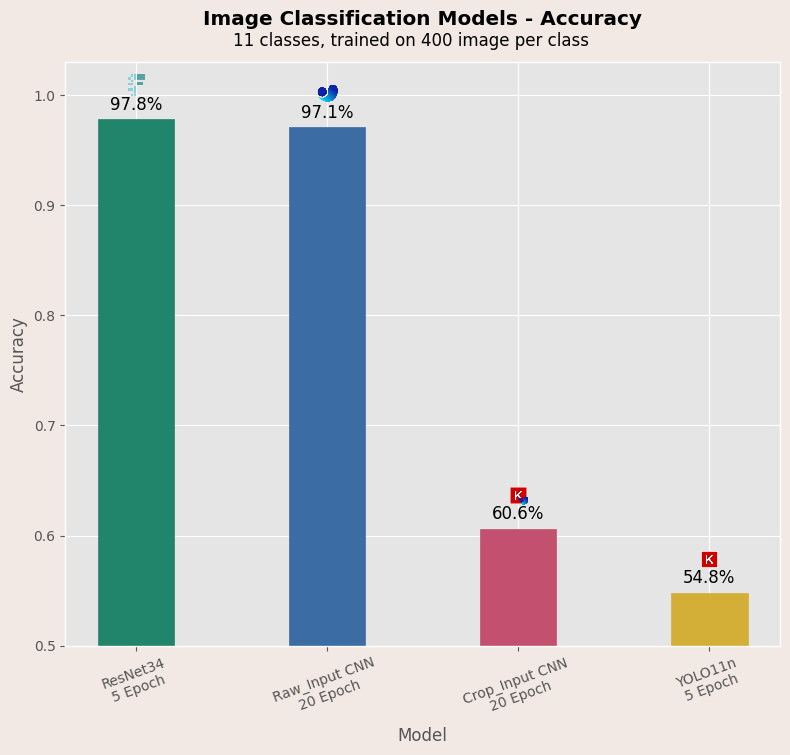

In [42]:
idtoname = {
    "fastAI": "ResNet34\n5 Epoch",
    "RawCNN": "Raw_Input CNN\n20 Epoch",
    "CleanCNN": "Crop_Input CNN\n20 Epoch",
    "YOLOv11": "YOLO11n\n5 Epoch"
}

model_list = plot_data.keys()
display_model_list = [idtoname[x] for x in model_list]

colordict = {
    "fastAI": "#20856a",
    "RawCNN": "#d4af37",
    "CleanCNN": "#c3506e",
    "YOLOv11": "#3b6ca3",
}
curImageDict = getImageDict()

raw_values = [x[0] for x in plot_data.values()]
label_values = [(lambda x: f"{x:.1%}")(x) for x in raw_values]

zipped = list(zip(raw_values, label_values, model_list))
zipped.sort(reverse=True)
raw_values, label_values, model_list = zip(*zipped)

plt.figure(figsize=(8, 8), facecolor=backgroundColor)
bars = plt.bar(display_model_list, raw_values, width=0.4)
for v, (val, label, model) in enumerate(zip(raw_values, label_values, model_list)):
    plt.text(v, val + 0.005, label, ha='center', va='bottom', fontsize=12, color="black")
for bar, model in zip(bars, model_list):
    x, y = bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03
    ab = AnnotationBbox(curImageDict[model], (x, y), xycoords='data', box_alignment=(0.5,0.5), frameon=False)
    plt.gca().add_artist(ab)
    bar.set_color(colordict[model])
plt.title("Image Classification Models - Accuracy", weight="bold", y=1.05)
plt.suptitle("11 classes, trained on 400 image per class", y=0.91, x=0.52)
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.03)
plt.tight_layout()
plt.show()

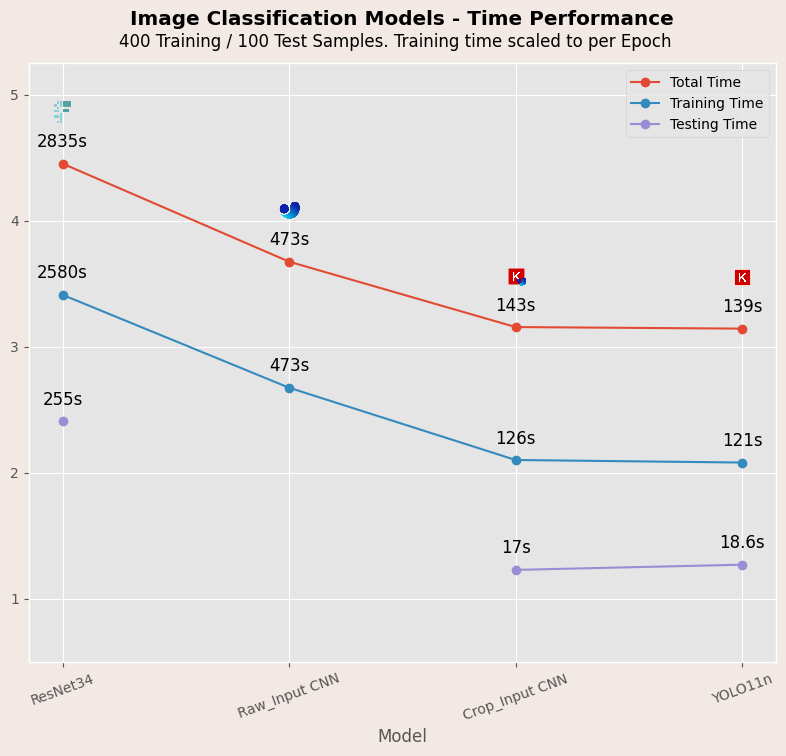

In [49]:
idtoname = {
    "fastAI": "ResNet34",
    "RawCNN": "Raw_Input CNN",
    "CleanCNN": "Crop_Input CNN",
    "YOLOv11": "YOLO11n"
}

modelepoch = {
    "fastAI": 5,
    "RawCNN": 20,
    "CleanCNN": 20,
    "YOLOv11": 5
}

traintimelambda = lambda x, y: y/(modelepoch[x])

model_list = plot_data.keys()
display_model_list = [idtoname[x] for x in model_list]

nanlambda = lambda x: not np.isnan(x) and x or 0
labellambda = lambda x: x>1e2 and f"{x:.0f}s" or f"{x:.3g}s"

curImageDict = getImageDict()

plt.figure(figsize=(8, 8), facecolor=backgroundColor)
def plotdata(raw_values, ylambda, sort, label, addimage):
    y_values = [ylambda(x) for x in raw_values]
    label_values = [labellambda(x) for x in raw_values]

    plt.plot(display_model_list, y_values, marker="o", label=label)
    for v, (val, label, model) in enumerate(zip(y_values, label_values, model_list)):
        plt.text(v, val + 0.1, label, ha='center', va='bottom', fontsize=12, color="black")
        if addimage:
            ab = AnnotationBbox(curImageDict[model], (v, val + 0.4), xycoords='data', box_alignment=(0.5,0.5), frameon=False)
            plt.gca().add_artist(ab)

traintime_values = [traintimelambda(x, y[1]) for x, y in plot_data.items()]
testtime_values = [y[2] for y in plot_data.values()]
totaltime_values = [nanlambda(traintime_values[x]) + nanlambda(testtime_values[x]) for x in range(len(traintime_values))]

zipped = list(zip(totaltime_values, traintime_values, testtime_values, model_list))
zipped.sort(reverse=True)
totaltime_values, traintime_values, testtime_values, model_list = zip(*zipped)

plotdata(
    totaltime_values,
    lambda x: math.log10(x) + 1,
    True,
    "Total Time",
    True
)

plotdata(
    traintime_values,
    lambda x: not np.isnan(x) and math.log10(x) or x,
    False,
    "Training Time",
    False
)

plotdata(
    testtime_values,
    lambda x: math.log10(x),
    False,
    "Testing Time",
    False
)

plt.title("Image Classification Models - Time Performance", weight="bold", y=1.05)
plt.suptitle("400 Training / 100 Test Samples. Training time scaled to per Epoch", y=0.91)
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.legend()
plt.ylim(0.5, 5.25)
plt.tight_layout()
plt.show()

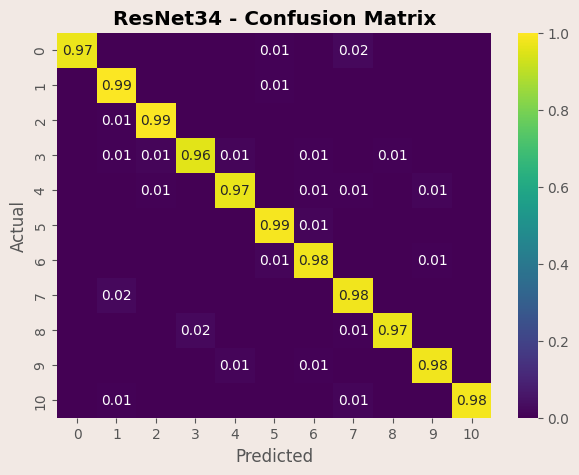

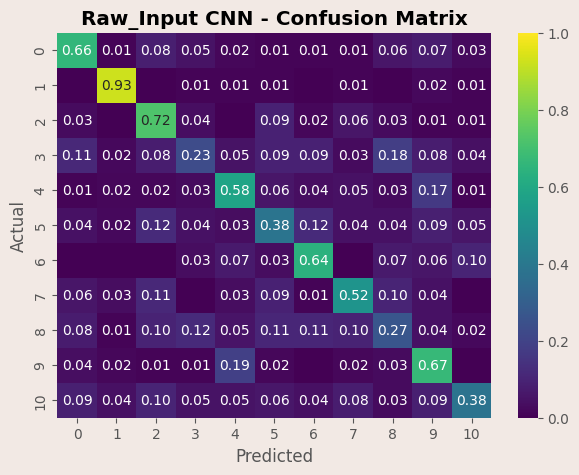

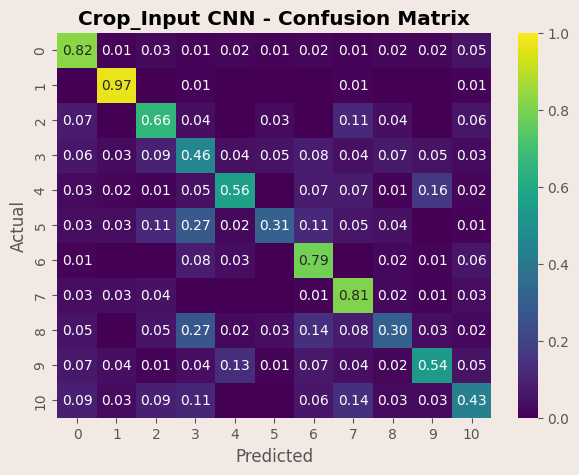

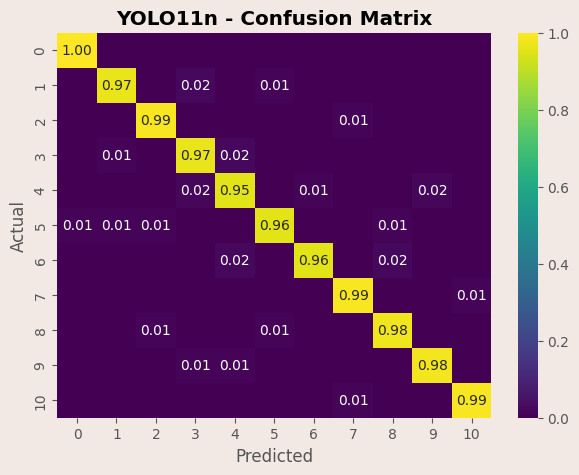

In [73]:
shortendict = {
    "fastAI": "ResNet34",
    "RawCNN": "Raw_Input CNN",
    "CleanCNN": "Crop_Input CNN",
    "YOLOv11": "YOLO11n"
}
shortenlambda = lambda x: shortendict[x] if x in shortendict.keys() else x
grouplambda = lambda x, y: f"{x:.2f}" if x > 0 else ""

for model, value in plot_data.items():
    matrix = value[3]
    norm = matrix / matrix.sum(axis=1, keepdims=True)
    group = [[grouplambda(norm[x,y], matrix[x,y]) for y in range(matrix.shape[1])] for x in range(matrix.shape[0])]

    plt.figure(figsize=(7, 5), facecolor=backgroundColor)
    sns.heatmap(norm, annot=group, fmt="", cmap="viridis",
                vmin=0, vmax=1)
    plt.title(f"{shortenlambda(model)} - Confusion Matrix", weight="bold")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

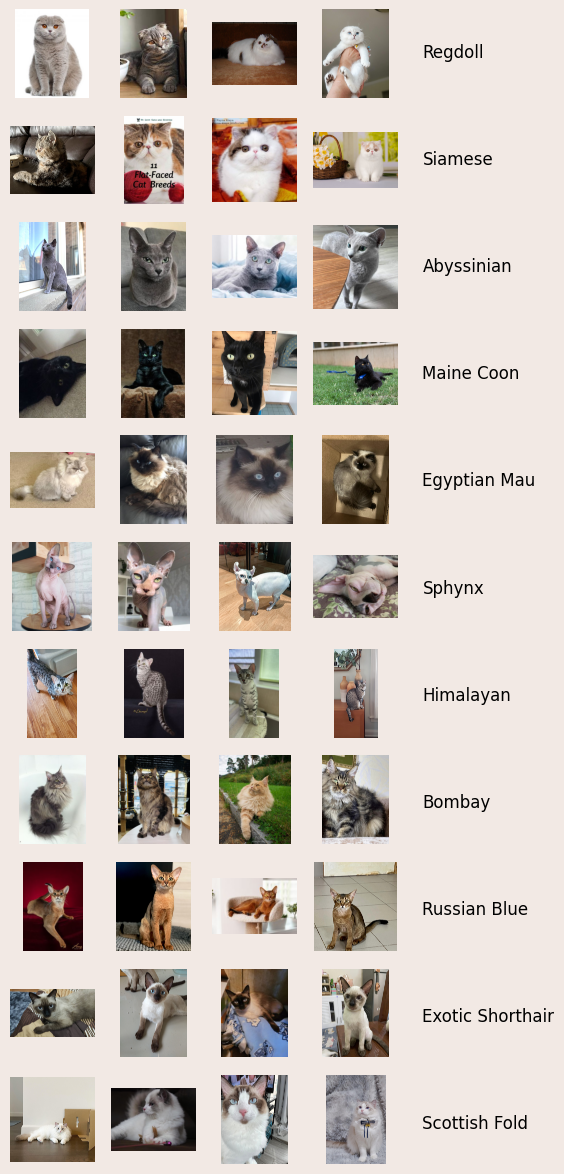

In [104]:
speciescount= len(traindf["species"].unique())
spacingscale, offset = 0.785, 0.03
spacinglambda = lambda x: offset + 0.5 + (spacingscale * (x-0.5))
imageperspecies = 4

fig = plt.figure(figsize=(5, 15), facecolor=backgroundColor)
gs = GridSpec(speciescount, imageperspecies, figure=fig)

for i, species in enumerate(traindf["species"].unique()):
    filepaths = traindf[traindf["species"] == species]["image"].values[:imageperspecies]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis("off")

    fig.text(0.95, spacinglambda(i/speciescount), species, fontsize=12, color="black", va="center", ha="left")


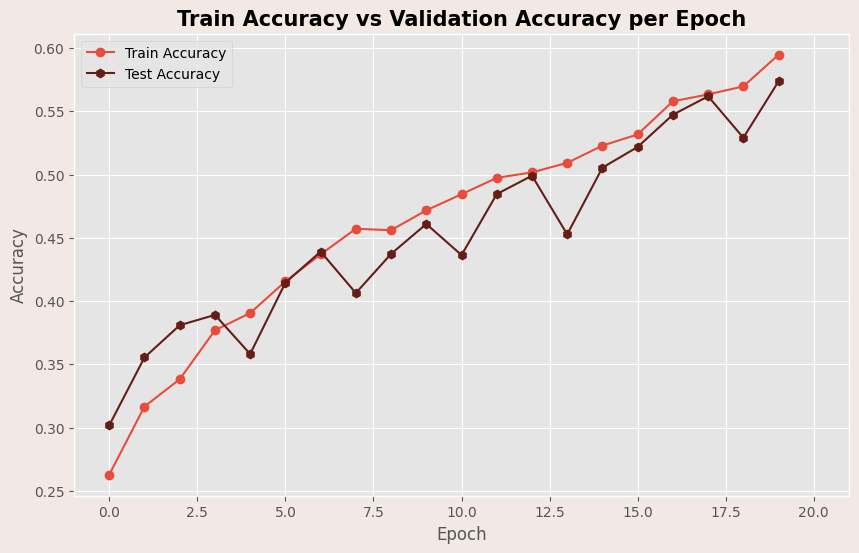

In [85]:
plt.figure(figsize=(10,6), facecolor=backgroundColor)
plt.plot(history['accuracy'],color="#E74C3C",marker='o')
plt.plot(history['val_accuracy'],color='#641E16',marker='h')
plt.title('Train Accuracy vs Validation Accuracy per Epoch', fontsize=15, weight="bold")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(-1, 21)
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='best')
plt.show()

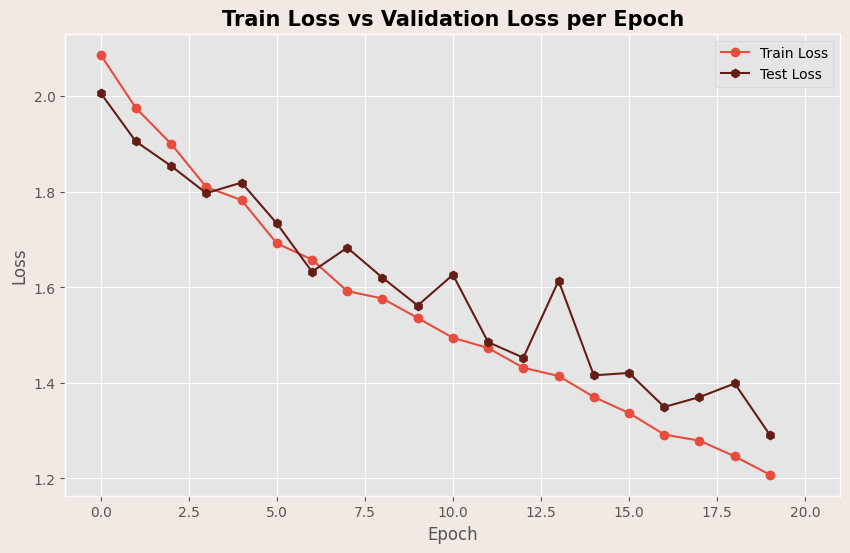

In [86]:
plt.figure(figsize=(10,6), facecolor=backgroundColor)
plt.plot(history['loss'],color="#E74C3C",marker='o')
plt.plot(history['val_loss'],color='#641E16',marker='h')
plt.title('Train Loss vs Validation Loss per Epoch', fontsize=15, weight="bold")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(-1, 21)
plt.legend(['Train Loss', 'Test Loss'], loc='best')
plt.show()